# **Proceso de investigacion de secuales sobre los video juegos**
**En este nootebok analizaremos de forma superficial el comportamiento de los juegos originales y sus secuelas.**
**Vindo si efectivamente es normal que la secuela fracase, y si no es asi, ver como se comportan generalmente**
### Para que sea mas veridico, analizaremos solo juegos que tengan mas de 1000 reseñanas, para que estos ya sean catalogados como juegos con relevancia
**Todos los juegos de esta data provienen de Steam**
***

## Librerias a ocupar
***

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import json
import re
import seaborn as sns
from pathlib import Path



### Abrir el archivo
***

In [110]:
with open("data/games_march2025_cleaned.csv", "r", encoding='utf-8') as archivo:
    data = pd.read_csv(archivo)

### Informacion basica de la data
Mas abajo se puede apreciar las distintas columnas y cuantas filas. Destacando las columnas de:

`name`
`recommendations`
`positive`
`negative`
`pct_pos_total`
`num_reviews_total`
`pct_pos_recent`
`num_reviews_recent`
`release_date`

Estas columnas seran mas importantes para mas adelante por que nos indican de una forma rapida si el juego es mejor que su secuela o viceversa
***

In [111]:
data.head()

,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,...,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,...,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,...,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,...,771,7101,74,0,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",87,1803832,92,17517
4,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,17,3.99,9,Edition Comparison Ultimate Edition The Tom Cl...,“One of the best first-person shooters ever ma...,"Tom Clancy's Rainbow Six® Siege is an elite, t...",NaN,...,682,2434,306,80,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",84,1168020,76,12608


In [112]:
data.columns

Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'score_rank', 'positive', 'negative', 'estimated_owners',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'discount',
       'peak_ccu', 'tags', 'pct_pos_total', 'num_reviews_total',
       'pct_pos_recent', 'num_reviews_recent'],
      dtype='object')

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89618 entries, 0 to 89617
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     89618 non-null  int64  
 1   name                      89618 non-null  object 
 2   release_date              89618 non-null  object 
 3   required_age              89618 non-null  int64  
 4   price                     89618 non-null  float64
 5   dlc_count                 89618 non-null  int64  
 6   detailed_description      89421 non-null  object 
 7   about_the_game            89398 non-null  object 
 8   short_description         89498 non-null  object 
 9   reviews                   10401 non-null  object 
 10  header_image              89618 non-null  object 
 11  website                   41114 non-null  object 
 12  support_url               44110 non-null  object 
 13  support_email             78798 non-null  object 
 14  window

## Proceso ed limpieza de datos
**Con las columnas de antes destacadas, las dejaramos en el Dataframe final para analizar el comportamiento de las secuelas y como les va generalmente**
***

In [114]:
# Eliminar algunas columnas para limpiar
# Elimino todas las columnas para quedarme solo con las cosas positivas
columnas_eliminar = ["detailed_description", "about_the_game", "short_description",
                      "reviews", "header_image", "website", "support_url", "support_email",
                      "metacritic_url", "achievements", "notes", "screenshots", "movies",
                      "tags", 'required_age', 'price', 'dlc_count',
                      'windows', 'mac', 'linux','supported_languages',
                      'full_audio_languages', 'packages', 'developers', 'publishers',
                      'categories', 'genres', 'estimated_owners',
                      'average_playtime_forever', 'average_playtime_2weeks',
                      'median_playtime_forever', 'median_playtime_2weeks', 'discount',
                      'peak_ccu', 'tags', "user_score", "score_rank", "metacritic_score",
                      "num_reviews_recent", "pct_pos_recent", "pct_pos_total", "recommendations"
                      ]

df_reseñas = data.drop(columns=columnas_eliminar)
df_reseñas.head()

,appid,name,release_date,positive,negative,num_reviews_total
0,730,Counter-Strike 2,2012-08-21,7480813,1135108,8632939
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,1487960,1024436,2513842
2,570,Dota 2,2013-07-09,1998462,451338,2452595
3,271590,Grand Theft Auto V Legacy,2015-04-13,1719950,250012,1803832
4,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,1152763,218446,1168020


## Limpieza de las columnas y datos atopicos

**Dado que las escala de metacritic_score no siempre esta actualizada o no tiene los datos lo voy a eliminar**

**- Asique me voy a quedar con solo las reseñas de steam que son solo usuarios**
***

In [115]:
# 1.- Mucha limpieza

# Les cambio el nombre a las columnas para mayor comodidad
df_reseñas_limpio = df_reseñas.rename(columns={"appid": "id",
                                              'name': 'Nombre',
                                              "positive" : "Reseñas_positivas",
                                              "negative" : "Reseñas_negativas",
                                              "num_reviews_total" : "Nun_total_de_reseñas",
                                              "release_date" : "Fecha_de_lanzamiento"}
                                              )
                   
df_reseñas_limpio['Fecha_de_lanzamiento'] = pd.to_datetime(df_reseñas_limpio['Fecha_de_lanzamiento'], errors='coerce')

# Elimino las columnas que deben ser claves
df_reseñas_limpio = df_reseñas_limpio.dropna(subset=["Nun_total_de_reseñas", "Nombre",
                                                    'Fecha_de_lanzamiento', 'Reseñas_positivas',
                                                    "Reseñas_negativas",
                                                    ])

# Elimino filas en las que hayan datos raros y minimo 1000 reseñas en total

# Definimos las condiciones para eliminar los datos que no queremos
condicion_total = df_reseñas_limpio['Nun_total_de_reseñas'] >= 1000

condicion_positivas = df_reseñas_limpio['Reseñas_positivas'] >= 0

condicion_negativas = df_reseñas_limpio['Reseñas_negativas'] >= 0

# Creamos un nuevo df con las nuevas condiciones
df_filtrado = df_reseñas_limpio[condicion_total & condicion_positivas & condicion_negativas]


# Hacemos que el df esta en orden ascendente por el año de lanzamiento
df_filtrado = df_filtrado.sort_values(by='Fecha_de_lanzamiento', ascending=True)

df_filtrado["Nun_total_de_reseñas"].describe()




count    6.232000e+03
mean     1.801543e+04
std      1.332200e+05
min      1.000000e+03
25%      1.637750e+03
50%      3.081500e+03
75%      8.741250e+03
max      8.632939e+06
Name: Nun_total_de_reseñas, dtype: float64

In [116]:
df_filtrado.head()

,id,Nombre,Fecha_de_lanzamiento,Reseñas_positivas,Reseñas_negativas,Nun_total_de_reseñas
1369,232770,POSTAL,1997-11-14,9487,961,10472
1918,20,Team Fortress Classic,1999-04-01,7500,1121,6482
1312,65540,Gothic 1,2001-03-15,14162,1209,11058
1640,40990,Mafia,2002-08-28,13116,1862,8150
131,240,Counter-Strike: Source,2004-11-01,172801,6697,124438


**La columna de total de reseñas no la ocupare ahora pero sirve para discriminar el total de reseñas**
***

## Avanzamos en la agrupacion los juegos con sus secuelas y ver si estos son bien resividos mediante las reseñas
En esta parte de la investigacion, es muy dificil separar juegos por sus secuelas, asque abran juegos que no esten con sus secuelas dado que cambian mucho su nombre. **Asique no es exacto este metodo y tiene margen de error**
***

In [117]:
# Hacer una funcion para encontrar una columna de nombre en comun
def obtener_nombre_base(titulo):
    # Si el título no es un string, devuélvelo tal cual
    if not isinstance(titulo, str):
        return titulo
    
    # Quitar subtítulos (ej. "Counter-Strike: Global Offensive" -> "Counter-Strike")
    base = re.sub(r':.*', '', titulo)
    
    # Quitar texto en paréntesis o corchetes (ej. "DOOM (2016)" -> "DOOM")
    base = re.sub(r'\s*\(.*\)', '', base)
    base = re.sub(r'\s*\[.*\]', '', base)
    
    # Quitar números arábigos o romanos al final (ej. "Half-Life 2" -> "Half-Life")
    # (Busca un espacio seguido de números o letras I, V, X al final de la línea)
    base = re.sub(r'\s+([IVX\d]+)$', '', base)
    
    # Quitar palabras comunes de "edición"
    base = re.sub(r'\s+(GOTY|Remastered|Definitive Edition)$', '', base, flags=re.IGNORECASE)
    
    return base.strip()

# Aplicamos la función a toda la columna 'Nombre'
df_filtrado['Nombre_Base'] = df_filtrado['Nombre'].apply(obtener_nombre_base)

# Contamos cuántos juegos hay en cada grupo de 'Nombre_Base'
conteo_franquicias = df_filtrado.groupby('Nombre_Base')['id'].count()

# Obtenemos la lista de nombres base que SÍ son franquicias (tienen > 1 juego)
nombres_franquicias = conteo_franquicias[conteo_franquicias > 1].index

# Filtramos nuestro DataFrame para quedarnos SÓLO con los juegos que pertenecen a una franquicia
df_franquicias = df_filtrado[df_filtrado['Nombre_Base'].isin(nombres_franquicias)]

df_franquicias.head()

,id,Nombre,Fecha_de_lanzamiento,Reseñas_positivas,Reseñas_negativas,Nun_total_de_reseñas,Nombre_Base
1369,232770,POSTAL,1997-11-14,9487,961,10472,POSTAL
1312,65540,Gothic 1,2001-03-15,14162,1209,11058,Gothic
1640,40990,Mafia,2002-08-28,13116,1862,8150,Mafia
131,240,Counter-Strike: Source,2004-11-01,172801,6697,124438,Counter-Strike
1477,320,Half-Life 2: Deathmatch,2004-11-01,12674,1291,9455,Half-Life


## Ordenamos los juegos por su secuela o de la misma franquicia y separamos los originales con sus secuelas
Definimos los originales con sus secuelas por el orden en que salieron 
***

In [118]:
# Ordenamos por nombre de franquicia y luego por fecha
df_franquicias = df_franquicias.sort_values(by=['Nombre_Base', 'Fecha_de_lanzamiento'])

# Creamos un DataFrame SÓLO con los originales (solo saca el primero)
df_originales = df_franquicias.groupby('Nombre_Base').first().reset_index()

# Creamos un DataFrame SÓLO con las secuelas (eliminamos los originales del total de juegos)
ids_originales = df_originales['id']
df_secuelas = df_franquicias[~df_franquicias['id'].isin(ids_originales)]

df_secuelas.head(10)

,id,Nombre,Fecha_de_lanzamiento,Reseñas_positivas,Reseñas_negativas,Nun_total_de_reseñas,Nombre_Base
4557,360640,12 Labours of Hercules II: The Cretan Bull,2015-06-05,1867,208,1707,12 Labours of Hercules
4972,1033420,9-nine-:Episode 2,2019-08-16,1491,23,1478,9-nine-
5948,1424660,9-nine-:Episode 4,2021-03-19,1089,20,1086,9-nine-
1036,1182900,A Plague Tale: Requiem,2022-10-17,17807,1721,15129,A Plague Tale
3341,1099410,A Total War Saga: TROY,2021-09-02,2303,914,2765,A Total War Saga
3191,1449200,AI: THE SOMNIUM FILES - nirvanA Initiative,2022-06-24,2704,406,2961,AI
2442,407530,ARK: The Survival Of The Fittest,2017-08-29,7733,3922,4495,ARK
288,2399830,ARK: Survival Ascended,2023-10-25,42267,29390,65032,ARK
5287,1589120,Above Snakes,2023-05-25,1258,393,1346,Above Snakes
1183,1017900,Age of Empires: Definitive Edition,2019-08-19,11384,2182,12610,Age of Empires


## Hacemos un dataframe que muestre los datos originales de cada juego pero lo empereja con el primer juego de la saga
**No deben aver juegos sin sagas o secuelas**
***

In [119]:
# Unimos secuelas con sus respectivos originales
df_comparativo = pd.merge(df_secuelas, df_originales, on='Nombre_Base', suffixes=('_Secuela', '_Original'))

# Hago una columna que muestre el año de diferencia entre la secuela y el original
df_comparativo['Años_de_diferencia'] = df_comparativo['Fecha_de_lanzamiento_Secuela'].dt.year - df_comparativo['Fecha_de_lanzamiento_Original'].dt.year

# Ahora df_comparativo tiene columnas como 'Nombre_Secuela', 'Nombre_Original',
# 'Reseñas_positivas_Secuela', 'Reseñas_positivas_Original', etc.
df_comparativo.head(10)

,id_Secuela,Nombre_Secuela,Fecha_de_lanzamiento_Secuela,Reseñas_positivas_Secuela,Reseñas_negativas_Secuela,Nun_total_de_reseñas_Secuela,Nombre_Base,id_Original,Nombre_Original,Fecha_de_lanzamiento_Original,Reseñas_positivas_Original,Reseñas_negativas_Original,Nun_total_de_reseñas_Original,Años_de_diferencia
0,360640,12 Labours of Hercules II: The Cretan Bull,2015-06-05,1867,208,1707,12 Labours of Hercules,342580,12 Labours of Hercules,2015-03-23,2814,192,2276,0
1,1033420,9-nine-:Episode 2,2019-08-16,1491,23,1478,9-nine-,976390,9-nine-:Episode 1,2019-01-31,1461,73,1459,0
2,1424660,9-nine-:Episode 4,2021-03-19,1089,20,1086,9-nine-,976390,9-nine-:Episode 1,2019-01-31,1461,73,1459,2
3,1182900,A Plague Tale: Requiem,2022-10-17,17807,1721,15129,A Plague Tale,752590,A Plague Tale: Innocence,2019-05-14,58010,4066,53926,3
4,1099410,A Total War Saga: TROY,2021-09-02,2303,914,2765,A Total War Saga,712100,A Total War Saga: THRONES OF BRITANNIA,2018-05-02,9829,4191,11583,3
5,1449200,AI: THE SOMNIUM FILES - nirvanA Initiative,2022-06-24,2704,406,2961,AI,948740,AI: The Somnium Files,2019-09-17,7434,680,7702,3
6,407530,ARK: The Survival Of The Fittest,2017-08-29,7733,3922,4495,ARK,346110,ARK: Survival Evolved,2017-08-27,603824,117279,542022,0
7,2399830,ARK: Survival Ascended,2023-10-25,42267,29390,65032,ARK,346110,ARK: Survival Evolved,2017-08-27,603824,117279,542022,6
8,1589120,Above Snakes,2023-05-25,1258,393,1346,Above Snakes,2209150,Above Snakes: Prologue,2023-03-24,0,0,1826,0
9,1017900,Age of Empires: Definitive Edition,2019-08-19,11384,2182,12610,Age of Empires,221380,Age of Empires II (Retired),2013-04-09,96700,4265,83103,6


## Creamos el Dataframe final con el que vamos a comparar los datos de las secuelas y crear graficos para ver el comportamiento
***

In [120]:
# Seleccionamos solo las columnas que nos interesan para la comparativa
columnas_finales = [
    'Nombre_Base',
    'Nombre_Original',
    'Reseñas_positivas_Original',
    'Reseñas_negativas_Original',
    'Nombre_Secuela',
    'Reseñas_positivas_Secuela',
    'Reseñas_negativas_Secuela',
    'Años_de_diferencia'
]
df_final = df_comparativo[columnas_finales]

# Creamos columnas de diferencia para ver el éxito
df_final['Diferencia_Positivas'] = df_final['Reseñas_positivas_Secuela'] - df_final['Reseñas_positivas_Original']
df_final['Diferencia_Negativas'] = df_final['Reseñas_negativas_Secuela'] - df_final['Reseñas_negativas_Original']

# Vemos las secuelas que MÁS mejoraron las reseñas positivas
print("Secuelas más exitosas (comparadas con el original):")
print(df_final.sort_values(by='Diferencia_Positivas', ascending=False).head(10))

# Vemos las secuelas que MÁS empeoraron (más reseñas negativas)
print("\nSecuelas que más decepcionaron (más reseñas negativas):")
print(df_final.sort_values(by='Diferencia_Negativas', ascending=False).head(10))

Secuelas más exitosas (comparadas con el original):
              Nombre_Base                               Nombre_Original  \
100        Counter-Strike                        Counter-Strike: Source   
32          Baldur's Gate               Baldur's Gate: Enhanced Edition   
75          Call of Duty®                      Call of Duty®: Black Ops   
111           DARK SOULS™                                DARK SOULS™ II   
52              Bloons TD                                   Bloons TD 5   
197               Fallout   Fallout 2: A Post Nuclear Role Playing Game   
551  The Binding of Isaac                          The Binding of Isaac   
434          Risk of Rain                           Risk of Rain (2013)   
608           Tomb Raider  Tomb Raider VI: The Angel of Darkness (2003)   
257                  Halo                         Halo: Spartan Assault   

     Reseñas_positivas_Original  Reseñas_negativas_Original  \
100                      172801                        6697

C:\Users\reyes\AppData\Local\Temp\ipykernel_1620\2563512707.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Diferencia_Positivas'] = df_final['Reseñas_positivas_Secuela'] - df_final['Reseñas_positivas_Original']
C:\Users\reyes\AppData\Local\Temp\ipykernel_1620\2563512707.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Diferencia_Negativas'] = df_final['Reseñas_negativas_Secuela'] - df_final['Reseñas_negativas_Original']


### Graficos del data frame
***

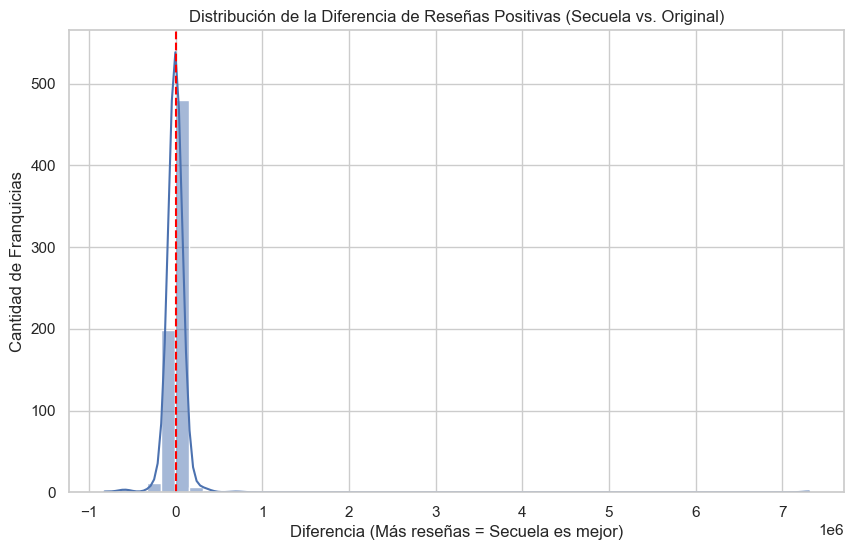

In [121]:

# Configuramos un estilo visual agradable
sns.set_theme(style="whitegrid")

# Histograma de la Diferencia
plt.figure(figsize=(10, 6))
sns.histplot(df_final['Diferencia_Positivas'], kde=True, bins=50) # kde=True añade la línea de densidad suave

# Añadimos una línea vertical en el 'cero' para ver la división
plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribución de la Diferencia de Reseñas Positivas (Secuela vs. Original)')
plt.xlabel('Diferencia (Más reseñas = Secuela es mejor)')
plt.ylabel('Cantidad de Franquicias')
plt.show()

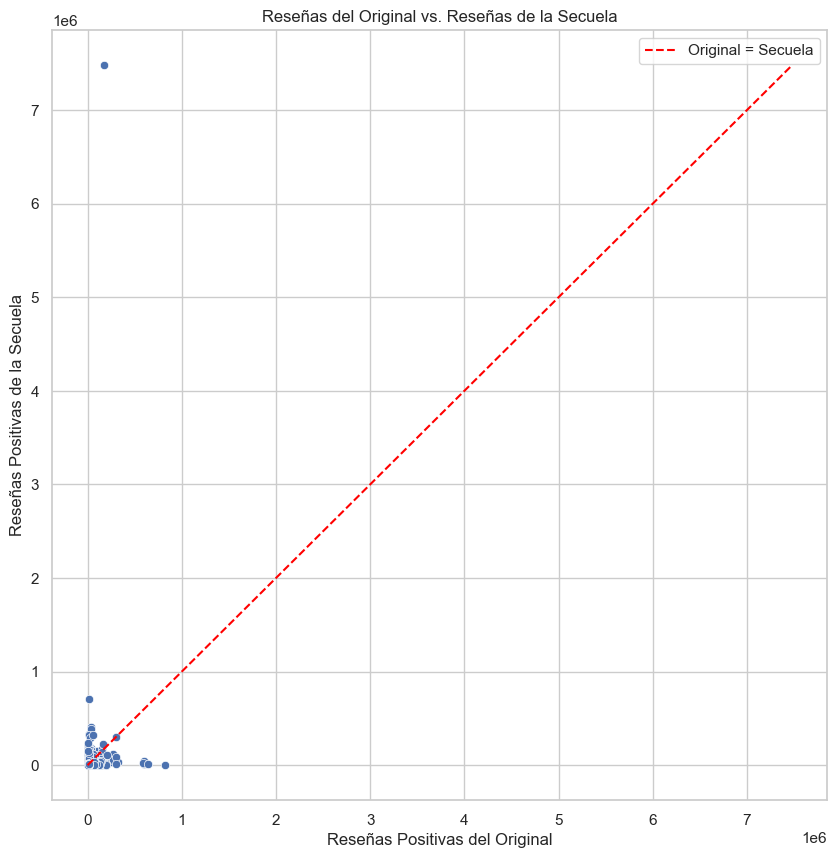

In [122]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_final,
    x='Reseñas_positivas_Original',
    y='Reseñas_positivas_Secuela'
)

# Dibujamos la línea y=x
# Primero encontramos el valor máximo para que la línea cubra todo el gráfico
max_val = max(df_final['Reseñas_positivas_Original'].max(), 
              df_final['Reseñas_positivas_Secuela'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Original = Secuela')

plt.title('Reseñas del Original vs. Reseñas de la Secuela')
plt.xlabel('Reseñas Positivas del Original')
plt.ylabel('Reseñas Positivas de la Secuela')
plt.legend()
plt.show()

### Vemos cual es el dato outlier que hace que los graficos de dispersen
Vemos que Counter-Strike 2 tubo mucha mas fama que el juego original, pero esto es una acepcion a la norma, asique por fines de estudio eliminare este dato para hacer una grafica mas representativa
***

In [123]:
df_outlier = df_final.sort_values(by='Diferencia_Positivas', ascending=False).head(1)

df_outlier.head()

,Nombre_Base,Nombre_Original,Reseñas_positivas_Original,Reseñas_negativas_Original,Nombre_Secuela,Reseñas_positivas_Secuela,Reseñas_negativas_Secuela,Años_de_diferencia,Diferencia_Positivas,Diferencia_Negativas
100,Counter-Strike,Counter-Strike: Source,172801,6697,Counter-Strike 2,7480813,1135108,8,7308012,1128411


In [124]:
indice_outlier = df_final['Diferencia_Positivas'].idxmax()

df_limpio_sin_outlier = df_final.drop(indice_outlier)

### Volvemos hacer los graficos para verlos detalladamente
Los siguientes graficos estan hechos en base a solamente las reseñas positivas, asique el resultado que se puede ver adelante puede cambiar de vista dependiendo si solamente lo ves asi o asabiendas que los juegos originales y secuelas casi nunca tienen la misma cantidad de reseñas, y este puede variar demasiado o no.
***

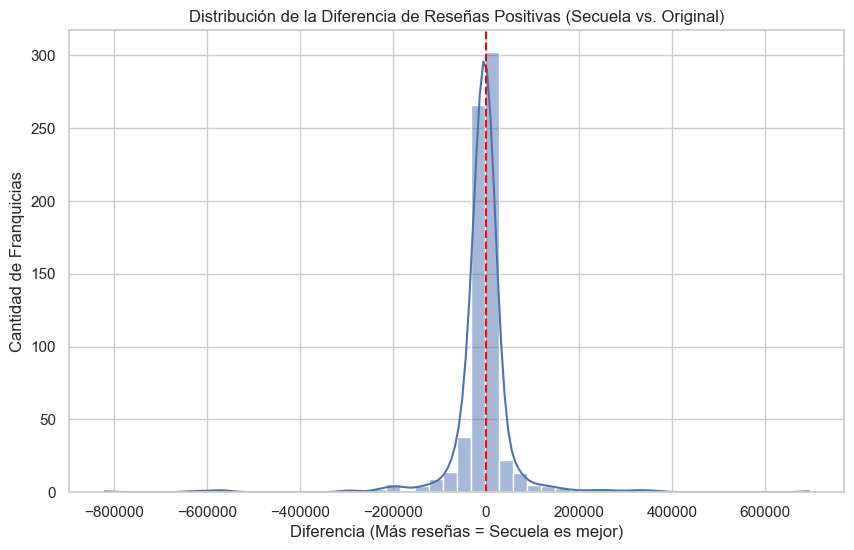

In [125]:
# Configuramos un estilo visual agradable
sns.set_theme(style="whitegrid")

# Histograma de la Diferencia
plt.figure(figsize=(10, 6))
sns.histplot(df_limpio_sin_outlier['Diferencia_Positivas'], kde=True, bins=50)

# Añadimos una línea vertical en el 'cero' para ver la división
plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribución de la Diferencia de Reseñas Positivas (Secuela vs. Original)')
plt.xlabel('Diferencia (Más reseñas = Secuela es mejor)')
plt.ylabel('Cantidad de Franquicias')
plt.show()

**Los datos que estan entre la linea roja hacia adelante se consideran como mejores que el juego original**
***

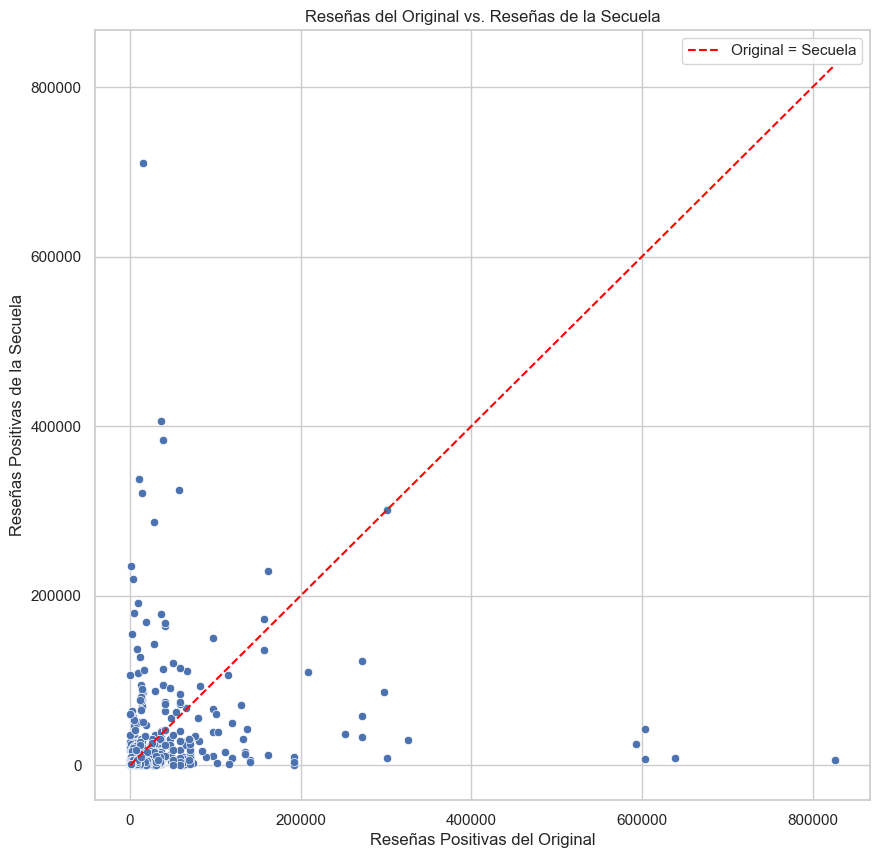

In [126]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_limpio_sin_outlier,
    x='Reseñas_positivas_Original',
    y='Reseñas_positivas_Secuela'
)

# Primero encontramos el valor máximo para que la línea cubra todo el gráfico
max_val = max(df_limpio_sin_outlier['Reseñas_positivas_Original'].max(), 
              df_limpio_sin_outlier['Reseñas_positivas_Secuela'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Original = Secuela')

plt.title('Reseñas del Original vs. Reseñas de la Secuela')
plt.xlabel('Reseñas Positivas del Original')
plt.ylabel('Reseñas Positivas de la Secuela')
plt.legend()
plt.show()

***
### Exitos de las secuelas comparados con la original

In [127]:
# Contar las categorías
total_secuelas_analizadas = len(df_limpio_sin_outlier)
secuelas_mejores = (df_limpio_sin_outlier['Diferencia_Positivas'] > 0).sum()
secuelas_peores = (df_limpio_sin_outlier['Diferencia_Positivas'] < 0).sum()
secuelas_iguales = (df_limpio_sin_outlier['Diferencia_Positivas'] == 0).sum()

# 2. Calcular Porcentajes
pct_mejores = (secuelas_mejores / total_secuelas_analizadas) * 100
pct_peores = (secuelas_peores / total_secuelas_analizadas) * 100

# 3. Mostrar los resultados
print("--- Análisis de Secuelas (vs. Originales) ---")
print(f"Total de franquicias: {total_secuelas_analizadas}")
print("")
print(f"Secuelas MEJORES que el original: {secuelas_mejores} ({pct_mejores:.2f}%)")
print(f"Secuelas PEORES que el original:  {secuelas_peores} ({pct_peores:.2f}%)")
print(f"Secuelas IGUALES al original:   {secuelas_iguales}")

--- Análisis de Secuelas (vs. Originales) ---
Total de franquicias: 706

Secuelas MEJORES que el original: 271 (38.39%)
Secuelas PEORES que el original:  428 (60.62%)
Secuelas IGUALES al original:   7


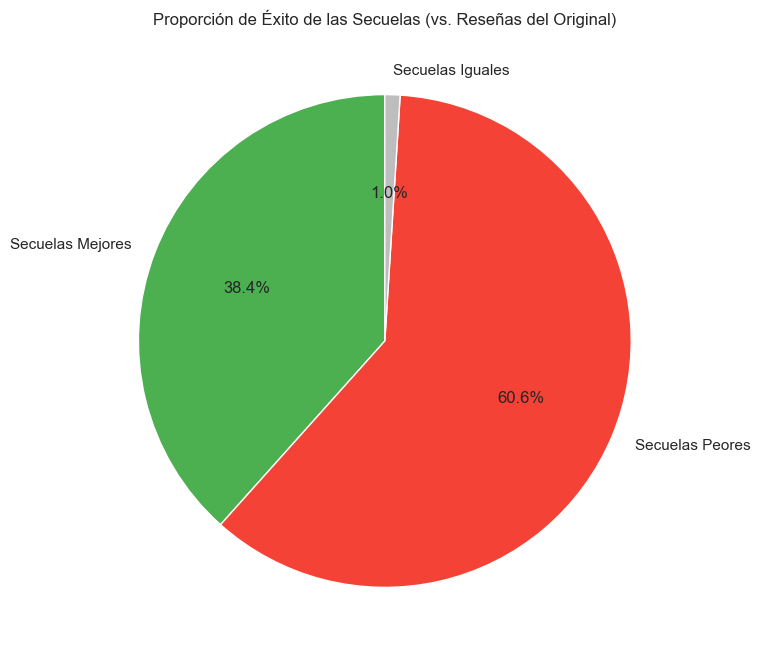

In [128]:
# Usando las variables de arriba creamos un grafico de torta
etiquetas = ['Secuelas Mejores', 'Secuelas Peores', 'Secuelas Iguales']
cantidades = [secuelas_mejores, secuelas_peores, secuelas_iguales]
colores = ['#4CAF50', '#F44336', '#BDBDBD'] # Verde, Rojo, Gris

plt.figure(figsize=(8, 8))
plt.pie(
    cantidades, 
    labels=etiquetas, 
    autopct='%1.1f%%', 
    startangle=90,
    colors=colores
)
plt.title('Proporción de Éxito de las Secuelas (vs. Reseñas del Original)')
plt.show()

## Resumen/analisis de los graficos
**La mayoria de las secuelas les va peor que a las originales. Pero estos resultados vienen de hacer una resta del total de reseñas positivas de la original a la secuela. Por ende, esto no indica que la mayoria de las secuelas son malas, si no que estubieron al alcance de las originales. Ya que ha estas les pudo ir muy bien si fuese un producto original, haciendo una comparacion entre las positivas y las negativas. Pero como no estamos contando las reseñas totales de los juegos, provoca que las secuelas que fueron bien resividas pero no fueron jugadas tantas o opinidas, se metieran a la bolsa de los juegos fracasados.**

***
# Conclusion provisional :
Las Secuelas Generan Menor Volumen de Reseñas Positivas, **No Necesariamente Peor Calidad**
Basado en los tres gráficos proporcionados, la conclusión principal es que la gran mayoría de las secuelas no logran igualar el volumen de popularidad (medido por el recuento total de reseñas positivas) de sus juegos originales.

**Esto, sin embargo, no significa que las secuelas sean de peor calidad, sino que simplemente atraen a menos jugadores o generan menos reseñas.**

Un juego original "legendario" puede acumular 800,000 reseñas positivas a lo largo de una década. Su secuela puede ser un éxito crítico (ej. 95% de aprobación), pero si solo la juegan 200,000 personas, tendrá menos reseñas positivas (digamos 190,000).
**Con este analisis y estas restricciones. Esa secuela contaría como "Peor" (190k vs 800k)**, aunque sea un juego de altísima calidad. Los gráficos demuestran que replicar el alcance de un éxito original es extremadamente difícil, lo que resulta en un menor volumen de reseñas positivas, aunque la calidad (medida por porcentaje) pueda ser igual o superior.

In [129]:
# Creo un csv con el data freme final limpio

carpeta = Path('data')  # La donde lo voy a guardar
archivo = carpeta / 'df_sin_outlier_resenas.csv' # El nombre del csv

# 4. Guardar
df_limpio_sin_outlier.to_csv(archivo, index=False) 

print(f"Guardado exitosamente en: {archivo}")


Guardado exitosamente en: data\df_sin_outlier_resenas.csv
